In [1]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import warnings
warnings.filterwarnings("ignore")

Basis for much of this: https://jfin-swufe.springeropen.com/track/pdf/10.1186/s40854-020-00217-x.pdf

# Personal Project - Compare the ability to predict cryptocurrency and futures prices using machine learning

## Start with acquiring crypto data
- Will acquire Bitcoin, Ethereum, and Litecoin data as these have some of the longest price histories and greatest liquidity

In [2]:
desired_products = ['BTC-USD',
 'ETH-USD',
 'LTC-USD']

In [3]:
results = acquire.get_data_from_csv()

In [4]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


### First iteration only using BTC

In [5]:
btc=prepared_results['BTC_USD']

No nulls

### Volatility:
- relative price range: RR
- range volatility estimator of Parkinson: sigma  - lags 1-7

#### Lagged log returns, 1-7 days earlier

In [6]:
btc = prepare.add_features(btc)

## Split data

In [7]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

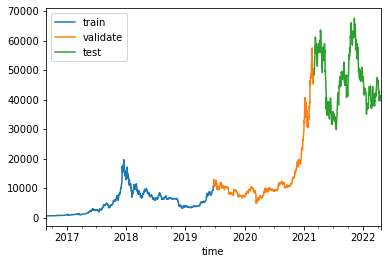

In [8]:
train.close.plot(label='train')
validate.close.plot(label='validate')
test.close.plot(label='test')
plt.legend()

# Modeling
- Will start with ARIMA
- After ARIMA will try regression and classification models

### Arima
- Based on https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- No validate dataset needed as ARIMA will perform one day prediction and then will be retrained for next day

In [9]:
result=adfuller(train.fwd_log_ret)
print("AD Fuller p stat < 0.05", result[1]<0.05)

AD Fuller p stat < 0.05 True


#### No differencing needed

### Partial Autocorrelation plot - for AR (p) term

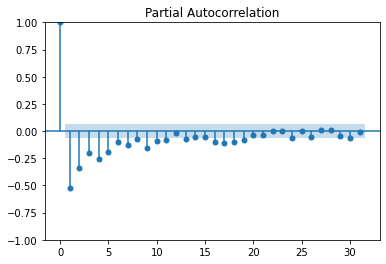

In [10]:
plot_pacf(train.fwd_log_ret.diff().dropna())
plt.show()

Looks like lags from 1-10 are significant.

### Autocorrelation plot (q) term

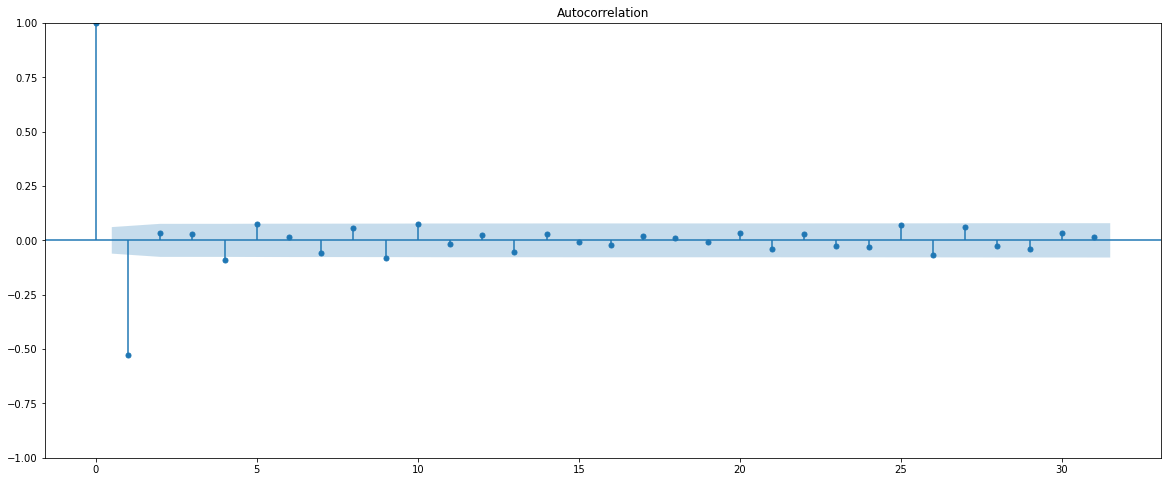

In [11]:
plt.rcParams.update({'figure.figsize':(20,8)})
plot_acf(train.fwd_log_ret.diff().dropna())
plt.show()

### Fix q as 1

In [13]:
def evaluate_arima_model(train, test, target, arima_order):
    """ Evaluates an ARIMA model based on arima_order argument, train set, test set, and target. 
    Outputs error, actual test values, and predictions for every timestep in test"""
    train_target = train[target]
    test_target = test[target]
    history = [x for x in train_target]

    # Make predictions
    predictions = []
    for t in range(len(test_target)):
        print(f"\tTesting {arima_order} {t}/{len(test_target)}", end="\r")
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        # Forecast returns forecast value, standard error, and confidence interval - only need forecast value ([0])
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # Adds the latest test value to history so it can be used to train
        history.append(test_target[t])
    error = mean_squared_error(test_target, predictions)
    print("\n")
    return error, test_target, predictions

def evaluate_models(train, test, target, p_values, d_values, q_values):
    mses=[]
    prediction_list=[]
    actual_test = []
    orders = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                orders.append(order)
                try:
                    mse, test_target, predictions = evaluate_arima_model(train, test, target, order)
                    mses.append(mse)
                    prediction_list.append(predictions)
                    actual_test.append(test_target)
                except KeyboardInterrupt:
                    print("Keyboard interrupt")
                    raise
                except:
                    print(f"{order} didn't work, continuing with next order")
                    continue
    results_df = pd.DataFrame.from_records(orders, columns = ['p','d','q'])
    results_df["mse"] = mses
    results_df["test_predictions"] = prediction_list
    results_df["test_actual"] = actual_test
    return results_df

In [14]:
# Evaluate on validate set
p_values = list(range(8))
d_values = [0]
q_values = [1]
results_df = evaluate_models(train, validate, 'fwd_log_ret', p_values, d_values, q_values)

	Testing (0, 0, 1) 619/620

	Testing (1, 0, 1) 619/620

	Testing (2, 0, 1) 619/620

	Testing (3, 0, 1) 619/620

	Testing (4, 0, 1) 619/620

	Testing (5, 0, 1) 619/620

	Testing (6, 0, 1) 619/620

	Testing (7, 0, 1) 619/620



In [15]:
results_df

,p,d,q,mse,test_predictions,test_actual
0,0,0,1,0.001821,"[0.00267540443695005, 0.002661961526788217, 0....",time 2019-06-23 0.018230 2019-06-24 0.06...
1,1,0,1,0.001822,"[0.003002166801198185, 0.003008561088074434, 0...",time 2019-06-23 0.018230 2019-06-24 0.06...
2,2,0,1,0.001817,"[0.0065101283954541594, 0.005818612746221494, ...",time 2019-06-23 0.018230 2019-06-24 0.06...
3,3,0,1,0.001820,"[0.006093039300593897, 0.004250277744224532, 0...",time 2019-06-23 0.018230 2019-06-24 0.06...
4,4,0,1,0.001829,"[0.0050493349696590145, 0.0012210152399325016,...",time 2019-06-23 0.018230 2019-06-24 0.06...
5,5,0,1,0.001838,"[0.006168978745058227, 0.00290747116499661, 0....",time 2019-06-23 0.018230 2019-06-24 0.06...
6,6,0,1,0.001840,"[0.004799987553241365, 0.0044213159340186995, ...",time 2019-06-23 0.018230 2019-06-24 0.06...
7,7,0,1,0.001842,"[0.0037865343185345905, 0.004445977778197009, ...",time 2019-06-23 0.018230 2019-06-24 0.06...


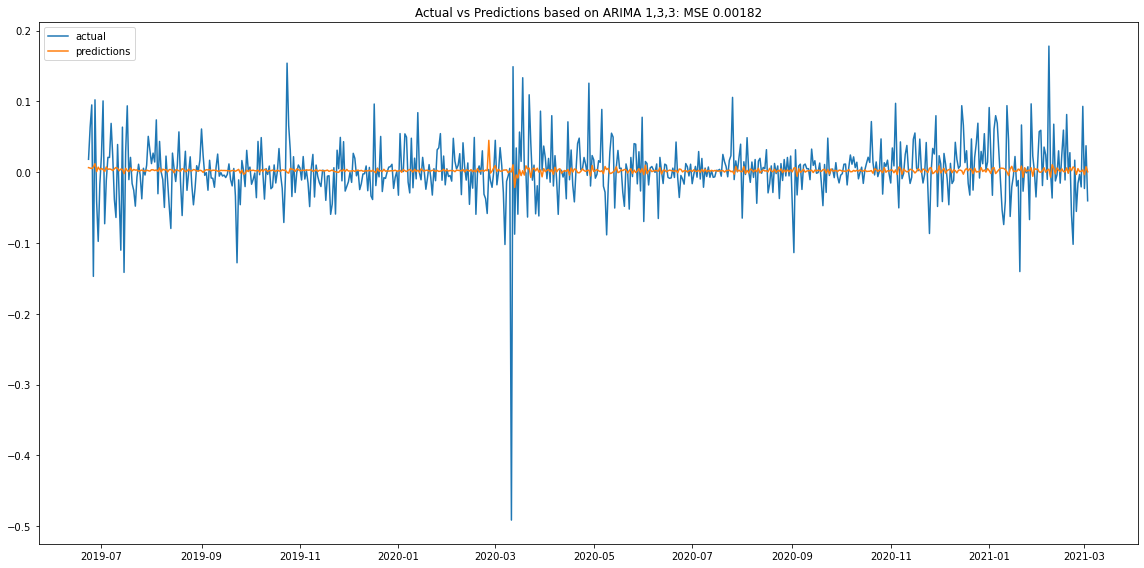

In [16]:
real = results_df.sort_values('mse').test_actual.array[0]
predictions = pd.Series(results_df.sort_values('mse').test_predictions.array[0], index = real.index)

plt.figure(figsize=(16,8))
plt.plot(real, label = "actual")
plt.plot(predictions, label = "predictions")
plt.title(f"Actual vs Predictions based on ARIMA 1,3,3: MSE {results_df.sort_values('mse').mse.array[0]:.5f}")
plt.legend()
plt.tight_layout()

In [17]:
# Check how well the predictions match up with actual returns purely based on sign of return
validate["prediction"] = predictions

validate[['fwd_log_ret','prediction']]
validate['same_sign'] = ((validate.fwd_log_ret<0) & (validate.prediction<0))|((validate.fwd_log_ret>0) & (validate.prediction>0))

validate.same_sign.mean()

0.5177419354838709

### Performance is not great for predicting the same sign of the return

Will set up a grid search for best parameters to use for ARIMA using close prices

In [18]:
result=adfuller(train.close.diff().dropna())
print("AD Fuller p stat < 0.05", result[1]<0.05)

AD Fuller p stat < 0.05 True


#### 1 differencing needed

### Partial Autocorrelation plot - for AR (p) term

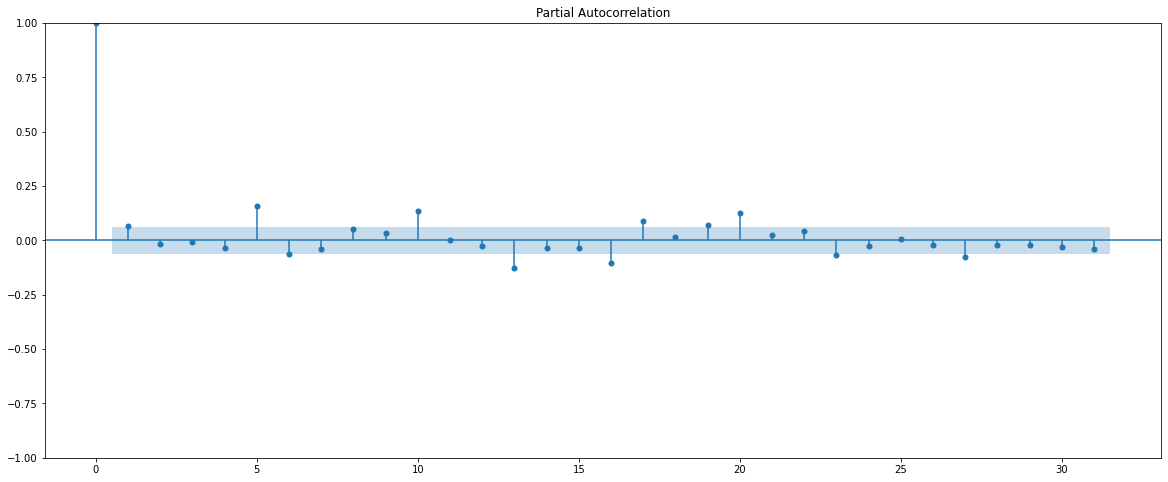

In [19]:
plot_pacf(train.close.diff().dropna())
plt.show()

Looks like lag 1 is significant.

### Autocorrelation plot (q) term

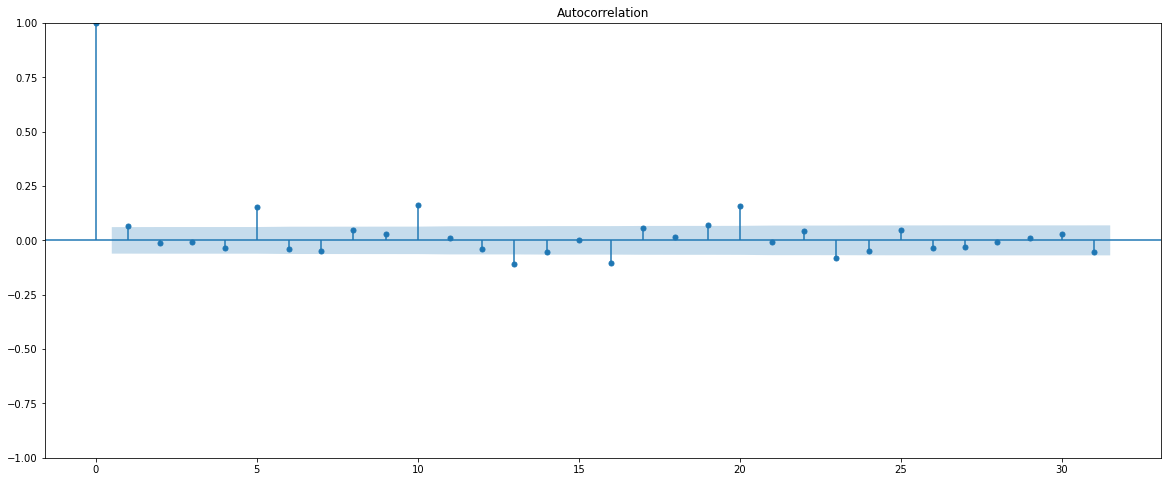

In [20]:
plt.rcParams.update({'figure.figsize':(20,8)})
plot_acf(train.close.diff().dropna())
plt.show()

### Fix q as 1

ARIMA order of 1,1,1 looks best

In [21]:
# Evaluate on validate set
p_values = [1]
d_values = [1]
q_values = [1]
results_df = evaluate_models(train, validate, 'close', p_values, d_values, q_values)

	Testing (1, 1, 1) 619/620



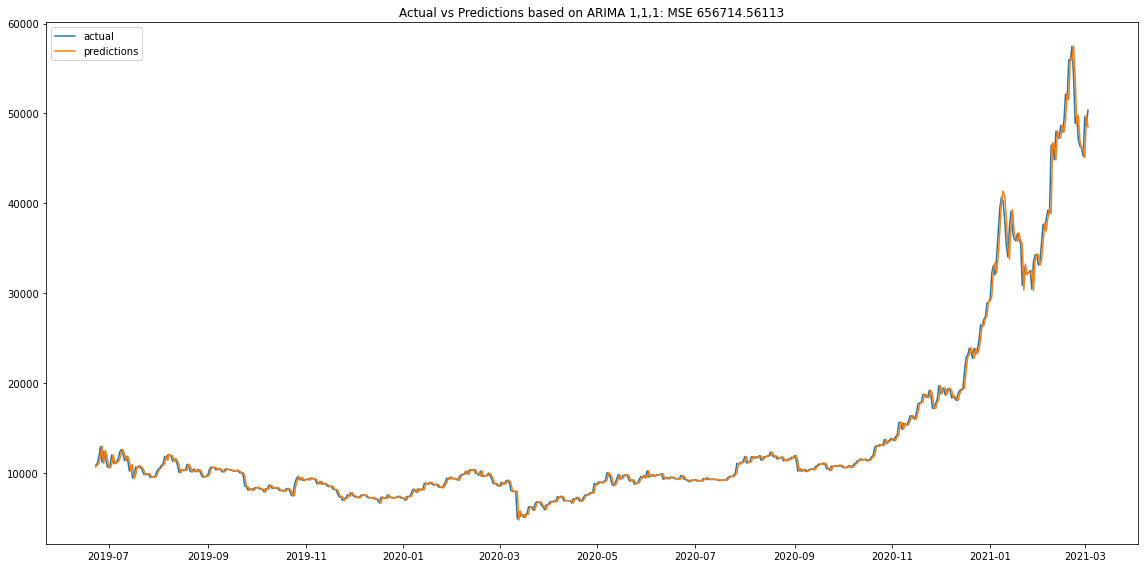

In [22]:
real = results_df.sort_values('mse').test_actual.array[0]
predictions = pd.Series(results_df.sort_values('mse').test_predictions.array[0], index = real.index)

plt.figure(figsize=(16,8))
plt.plot(real, label = "actual")
plt.plot(predictions, label = "predictions")
plt.title(f"Actual vs Predictions based on ARIMA 1,1,1: MSE {results_df.sort_values('mse').mse.array[0]:.5f}")
plt.legend()
plt.tight_layout()

In [23]:
predictions

time
2019-06-23    10658.659063
2019-06-24    10849.959753
2019-06-25    11032.772607
2019-06-26    11802.814547
2019-06-27    12972.839456
                  ...     
2021-02-27    46181.611300
2021-02-28    46054.167223
2021-03-01    45081.694209
2021-03-02    49837.303004
2021-03-03    48506.342865
Length: 620, dtype: float64

In [24]:
# Check how well the predictions match up with actual returns purely based on sign of return
validate["prediction"] = predictions
validate["error"] = (validate.close - validate.prediction)**2
validate[['close','prediction','error']]

# validate['same_sign'] = ((validate.close<0) & (validate.prediction<0))|((validate.fwd_log_ret>0) & (validate.prediction>0))

# validate.same_sign.mean()

,close,prediction,error
time,,,
2019-06-23,10833.02,10658.659063,3.040174e+04
2019-06-24,11032.32,10849.959753,3.325526e+04
2019-06-25,11755.53,11032.772607,5.223782e+05
2019-06-26,12927.44,11802.814547,1.264782e+06
2019-06-27,11159.29,12972.839456,3.288962e+06
...,...,...,...
2021-02-27,46180.75,46181.611300,7.418376e-01
2021-02-28,45231.75,46054.167223,6.763701e+05
2021-03-01,49639.40,45081.694209,2.077268e+07


Text(0.5, 1.0, 'Prediction vs Actual Close - Still a Linear Trend Evident so Have Not Successfully Predicted with ARIMA')

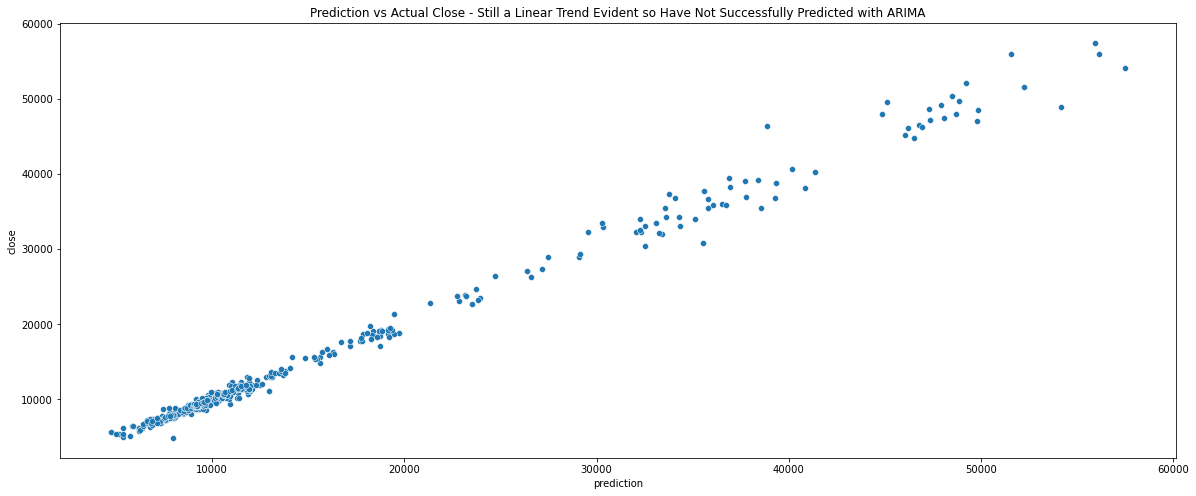

In [25]:
sns.scatterplot(validate.prediction, validate.close)
plt.title("Prediction vs Actual Close - Still a Linear Trend Evident so Have Not Successfully Predicted with ARIMA")